Name: Shubhajeet Das <br />
Roll No.: 24AI10013 <br />
DL Lab Assignment 5 - TRANSFER LEARNING

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random
SEED = 42
def set_all_seeds(seed):
    """
    Sets seeds for NumPy and PyTorch (not scikit-learn)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_all_seeds(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/caltech256")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'caltech256' dataset.
Path to dataset files: /kaggle/input/caltech256


## Assignment: Transfer Learning on the Caltech-256 Dataset (20 Marks)
# Question 1: Dataset Loading and Preprocessing (3 Marks)

a) Load the Caltech-256 dataset for multi-class image classification.

b) Apply suitable image transformations, including resizing and normalization, to prepare the dataset for training.

c) Create training, validation, and test data loaders with appropriate batch size and shuffling strategy.

In [ ]:
import os
import torchvision.transforms as transforms
import torchvision.datasets as datasets
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() // 2 or 2

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = os.path.join(path, '256_ObjectCategories')
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)
val_test_dataset = datasets.ImageFolder(root=data_dir, transform=test_val_transforms)
num_classes = len(full_dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 257


In [ ]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

indices = list(range(total_size))
generator = torch.Generator().manual_seed(SEED)
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(val_test_dataset, val_indices)
test_dataset = torch.utils.data.Subset(val_test_dataset, test_indices)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 21424
Validation set size: 4591
Test set size: 4592


In [ ]:
from torch.utils.data import Dataset, DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("Dataset loading and preprocessing complete. DataLoaders created.")

Dataset loading and preprocessing complete. DataLoaders created.



# Question 2: Data Visualization and Distribution Analysis (3 Marks)

a) Plot the class-wise distribution of samples in the dataset.

b) Display a fixed number of sample images (e.g., four) from different classes along with their class labels.


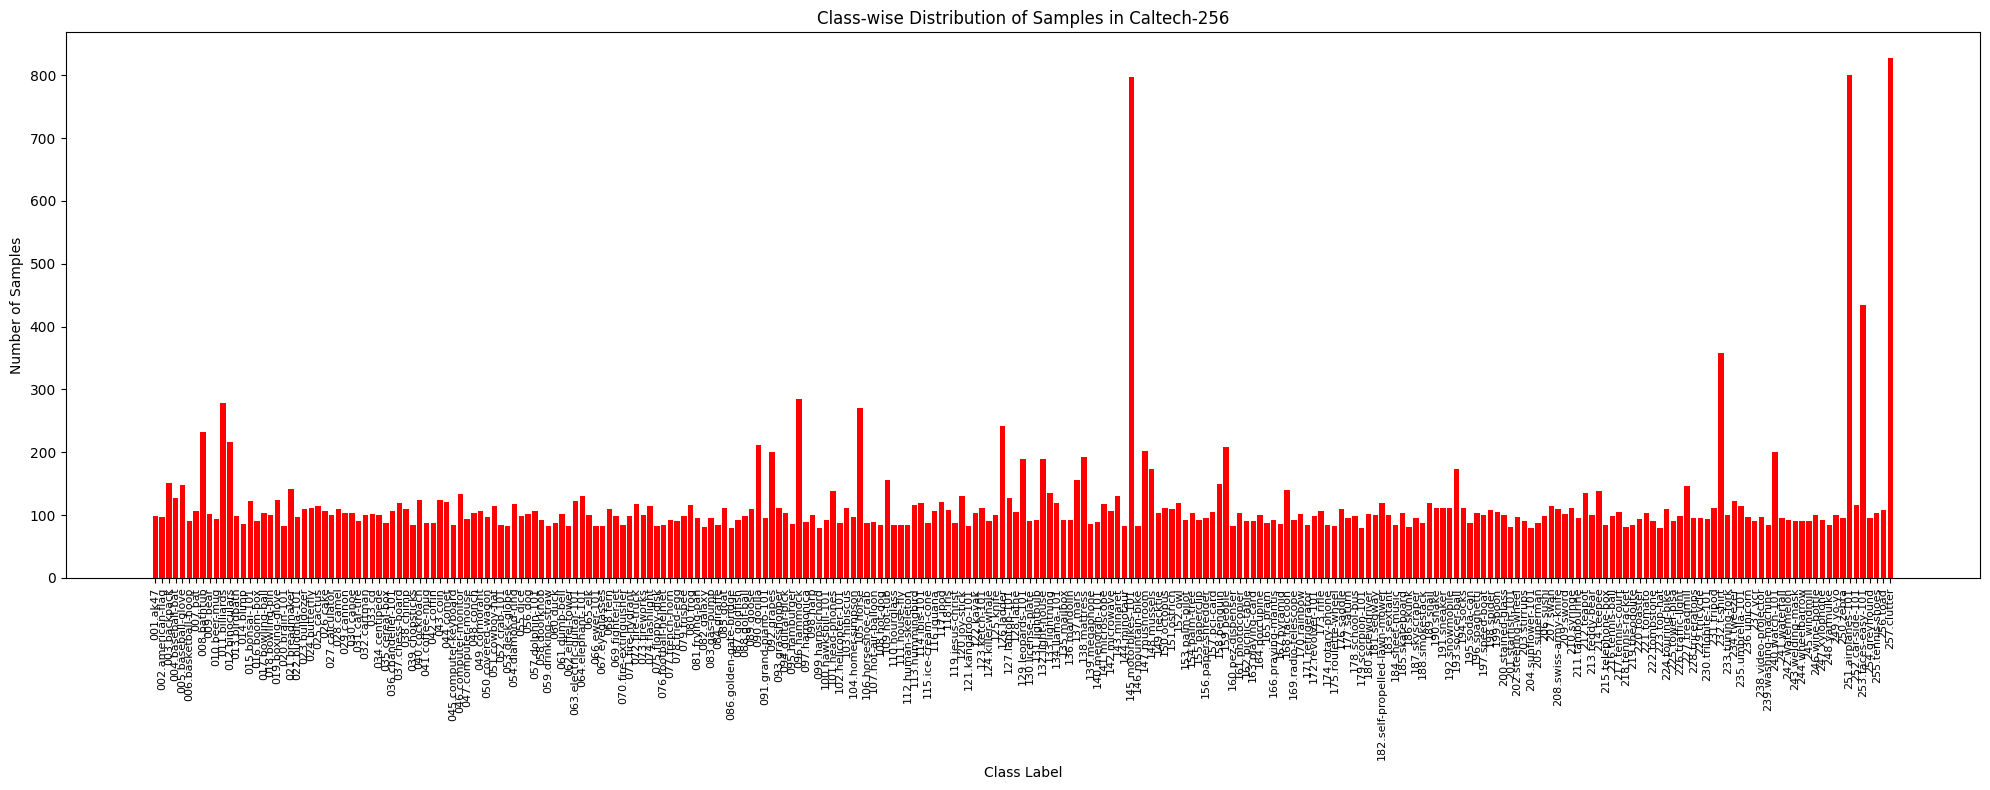

Class distribution plotted.


In [ ]:
class_counts = {}
for label in full_dataset.targets:
    if label not in class_counts:
        class_counts[label] = 0
    class_counts[label] += 1

sorted_class_counts = dict(sorted(class_counts.items()))

class_names = [full_dataset.classes[i] for i in sorted_class_counts.keys()]
counts = list(sorted_class_counts.values())

plt.figure(figsize=(20, 8))
plt.bar(class_names, counts, color='red')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class-wise Distribution of Samples in Caltech-256')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

print("Class distribution plotted.")

In [ ]:
num_classes = len(full_dataset.classes)
print(num_classes)

257


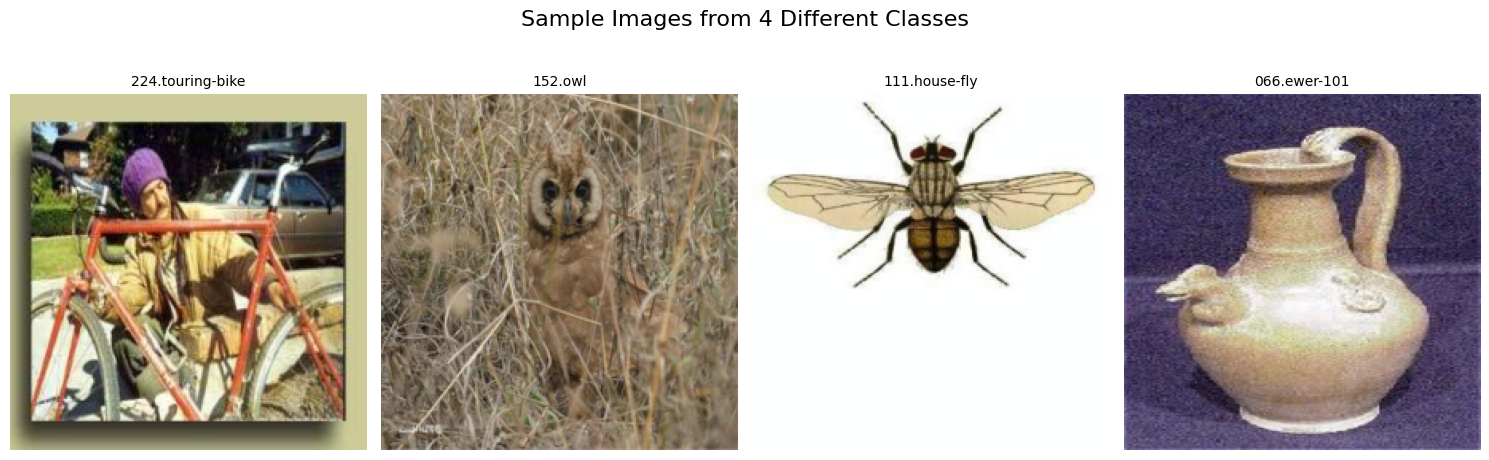

In [ ]:
num_sample_images = 4
targets = np.array(full_dataset.targets)
selected_classes_indices = random.sample(range(len(full_dataset.classes)), num_sample_images)
indices_to_fetch = []
for cls_idx in selected_classes_indices:
    matched_indices = np.where(targets == cls_idx)[0]
    indices_to_fetch.append(random.choice(matched_indices))

sample_images = [full_dataset[i][0] for i in indices_to_fetch]
sample_labels = [full_dataset.classes[targets[i]] for i in indices_to_fetch]

fig, axes = plt.subplots(1, num_sample_images, figsize=(15, 5))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i, ax in enumerate(axes):
    img = sample_images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(sample_labels[i], fontsize=10)
    ax.axis('off')
plt.suptitle(f'Sample Images from {num_sample_images} Different Classes', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Question 3: Baseline CNN Model (4 Marks)

a) Design and implement a baseline Convolutional Neural Network trained from scratch for multi-class classification.

b) Select an appropriate loss function and optimizer for training the CNN.
Justify your choices for this classification task.


In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=257):
        super(BaselineCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
import torch.optim as optim
baseline_model = BaselineCNN(num_classes=num_classes).to(device)
print("Baseline CNN model instantiated.")
summary(baseline_model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))
criterion = nn.CrossEntropyLoss()
print("Loss function (CrossEntropyLoss) instantiated.")
optimizer = optim.Adam(baseline_model.parameters(), lr=0.001)
print("Optimizer (Adam) instantiated.")

Baseline CNN model instantiated.
Loss function (CrossEntropyLoss) instantiated.
Optimizer (Adam) instantiated.



# Question 4: Transfer Learning Models (3 Marks)

a) Implement a transfer learning model using a pretrained CNN (your choice) with the backbone frozen and a newly initialized classification head.

b) Implement another transfer learning model with partial fine-tuning of the pretrained backbone.Describe how partial fine-tuning differs from full freezing and when it is beneficial.


In [ ]:
import torchvision.models as models
frozen_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
print("Loaded pretrained ResNet-18 for frozen backbone model.")
for param in frozen_model.parameters():
    param.requires_grad = False
num_ftrs = frozen_model.fc.in_features
frozen_model.fc = nn.Linear(num_ftrs, num_classes)
frozen_model = frozen_model.to(device)
print("Frozen backbone model instantiated and moved to device.")
optimizer_frozen = optim.Adam(filter(lambda p: p.requires_grad, frozen_model.parameters()), lr=0.001)
print("Optimizer defined: Adam (targeting only trainable parameters).")

Loaded pretrained ResNet-18 for frozen backbone model.
Frozen backbone model instantiated and moved to device.
Optimizer defined: Adam (targeting only trainable parameters).


In [ ]:
partial_finetune_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
print("Loaded pretrained ResNet-18 for partial fine-tuning.")
classifier_params = []
backbone_params = []
for param in partial_finetune_model.parameters():
    param.requires_grad = False
unfreeze_layers = ['layer3', 'layer4']
for name, child in partial_finetune_model.named_children():
    if name in unfreeze_layers:
        print(f"Unfreezing layer: {name}")
        for param in child.parameters():
            param.requires_grad = True
            backbone_params.append(param)
num_ftrs_finetune = partial_finetune_model.fc.in_features
partial_finetune_model.fc = nn.Linear(num_ftrs_finetune, num_classes)
for param in partial_finetune_model.fc.parameters():
    param.requires_grad = True
    classifier_params.append(param)

partial_finetune_model = partial_finetune_model.to(device)
print("\nSummary of Partially Fine-tuned Model:")
summary(partial_finetune_model, input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE))
trainable_params_finetune = sum(p.numel() for p in partial_finetune_model.parameters() if p.requires_grad)
total_params_finetune = sum(p.numel() for p in partial_finetune_model.parameters())
print(f"\nTrainable parameters: {trainable_params_finetune}")
print(f"Total parameters: {total_params_finetune}")
optimizer_finetune = optim.Adam([
    {'params': classifier_params, 'lr': 1e-4},
    {'params': backbone_params, 'lr': 1e-5}
])
print("Optimizer (Adam) instantiated with differential learning rates.")

Loaded pretrained ResNet-18 for partial fine-tuning.
Unfreezing layer: layer3
Unfreezing layer: layer4

Summary of Partially Fine-tuned Model:

Trainable parameters: 10625281
Total parameters: 11308353
Optimizer (Adam) instantiated with differential learning rates.



# Question 5: Training, Evaluation, and Analysis (5 Marks)

a) Train all three models (CNN from scratch, frozen-backbone model, partially fine-tuned model) and analyze their training behavior.

b) Evaluate the models using suitable metrics such as accuracy and F1-score.
Briefly discuss which model performs best and why.


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
def train_model(net, train_iter, val_iter, loss_fn, opt, num_epochs=15, tag="Model"):
    print(f"Training {tag}...")
    logs = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(num_epochs):
        net.train()
        t_loss, t_correct, t_total = 0.0, 0, 0
        for inputs, targets in tqdm(train_iter, leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            opt.zero_grad()
            preds = net(inputs)
            loss = loss_fn(preds, targets)
            loss.backward()
            opt.step()
            t_loss += loss.item()
            t_correct += (preds.argmax(1) == targets).sum().item()
            t_total += targets.size(0)
        net.eval()
        v_loss, v_correct, v_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_iter:
                inputs, targets = inputs.to(device), targets.to(device)
                preds = net(inputs)
                loss = loss_fn(preds, targets)

                v_loss += loss.item()
                v_correct += (preds.argmax(1) == targets).sum().item()
                v_total += targets.size(0)

        metrics = {
            'train_loss': t_loss / len(train_iter),
            'train_acc': t_correct / t_total,
            'val_loss': v_loss / len(val_iter),
            'val_acc': v_correct / v_total
        }
        for k, v in metrics.items(): logs[k].append(v)
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Acc: {metrics['train_acc']:.4f} | "
              f"Val Acc: {metrics['val_acc']:.4f}")
    return logs

def evaluate_model(net, data_iter, tag="Model"):
    net.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, targets in data_iter:
            inputs, targets = inputs.to(device), targets.to(device)
            preds = net(inputs)
            _, top_pred = torch.max(preds.data, 1)
            y_pred.extend(top_pred.cpu().numpy())
            y_true.extend(targets.cpu().numpy())
    final_acc = accuracy_score(y_true, y_pred)
    final_f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n--- Evaluation Results for {tag} ---")
    print(f"Accuracy: {final_acc:.4f}")
    print(f"F1 Score (Weighted): {final_f1:.4f}")
    return final_acc, final_f1

epochs = 15
scratch = train_model(baseline_model, train_loader, val_loader, criterion, optimizer, epochs, "Baseline CNN")

Training Baseline CNN...


Epoch 1/15 | Train Acc: 0.0795 | Val Acc: 0.1305


Epoch 2/15 | Train Acc: 0.1471 | Val Acc: 0.1662


Epoch 3/15 | Train Acc: 0.1980 | Val Acc: 0.2165


Epoch 4/15 | Train Acc: 0.2565 | Val Acc: 0.2365


Epoch 5/15 | Train Acc: 0.3233 | Val Acc: 0.2485


Epoch 6/15 | Train Acc: 0.3956 | Val Acc: 0.2501


Epoch 7/15 | Train Acc: 0.4764 | Val Acc: 0.2431


Epoch 8/15 | Train Acc: 0.5418 | Val Acc: 0.2464


Epoch 9/15 | Train Acc: 0.5953 | Val Acc: 0.2492


Epoch 10/15 | Train Acc: 0.6471 | Val Acc: 0.2416


Epoch 11/15 | Train Acc: 0.6902 | Val Acc: 0.2392


Epoch 12/15 | Train Acc: 0.7163 | Val Acc: 0.2424


Epoch 13/15 | Train Acc: 0.7478 | Val Acc: 0.2335


Epoch 14/15 | Train Acc: 0.7727 | Val Acc: 0.2416


Epoch 15/15 | Train Acc: 0.7866 | Val Acc: 0.2294


In [ ]:
torch.save(baseline_model, "baseline_model.pth")

In [ ]:
frozen = train_model(frozen_model, train_loader, val_loader, criterion, optimizer_frozen, epochs, "Frozen ResNet18")

Training Frozen ResNet18...


Epoch 1/15 | Train Acc: 0.5680 | Val Acc: 0.7323


Epoch 2/15 | Train Acc: 0.7861 | Val Acc: 0.7589


Epoch 3/15 | Train Acc: 0.8256 | Val Acc: 0.7641


Epoch 4/15 | Train Acc: 0.8500 | Val Acc: 0.7652


Epoch 5/15 | Train Acc: 0.8681 | Val Acc: 0.7650


Epoch 6/15 | Train Acc: 0.8803 | Val Acc: 0.7665


Epoch 7/15 | Train Acc: 0.8906 | Val Acc: 0.7711


Epoch 8/15 | Train Acc: 0.9005 | Val Acc: 0.7611


Epoch 9/15 | Train Acc: 0.9094 | Val Acc: 0.7750


Epoch 10/15 | Train Acc: 0.9169 | Val Acc: 0.7748


Epoch 11/15 | Train Acc: 0.9221 | Val Acc: 0.7682


Epoch 12/15 | Train Acc: 0.9265 | Val Acc: 0.7602


Epoch 13/15 | Train Acc: 0.9340 | Val Acc: 0.7637


Epoch 14/15 | Train Acc: 0.9342 | Val Acc: 0.7704


Epoch 15/15 | Train Acc: 0.9363 | Val Acc: 0.7717


In [ ]:
torch.save(frozen_model, "frozen_model.pth")

In [ ]:
finetune = train_model(partial_finetune_model, train_loader, val_loader, criterion, optimizer_finetune, epochs, "Fine-Tuned ResNet18")

Training Fine-Tuned ResNet18...


Epoch 1/15 | Train Acc: 0.2660 | Val Acc: 0.4988


Epoch 2/15 | Train Acc: 0.6424 | Val Acc: 0.6866


Epoch 3/15 | Train Acc: 0.7635 | Val Acc: 0.7462


Epoch 4/15 | Train Acc: 0.8169 | Val Acc: 0.7700


Epoch 5/15 | Train Acc: 0.8522 | Val Acc: 0.7839


Epoch 6/15 | Train Acc: 0.8782 | Val Acc: 0.7981


Epoch 7/15 | Train Acc: 0.9046 | Val Acc: 0.8042


Epoch 8/15 | Train Acc: 0.9222 | Val Acc: 0.8079


Epoch 9/15 | Train Acc: 0.9415 | Val Acc: 0.8105


Epoch 10/15 | Train Acc: 0.9546 | Val Acc: 0.8173


Epoch 11/15 | Train Acc: 0.9679 | Val Acc: 0.8188


Epoch 12/15 | Train Acc: 0.9744 | Val Acc: 0.8186


Epoch 13/15 | Train Acc: 0.9842 | Val Acc: 0.8216


Epoch 14/15 | Train Acc: 0.9892 | Val Acc: 0.8242


Epoch 15/15 | Train Acc: 0.9936 | Val Acc: 0.8260


In [ ]:
torch.save(partial_finetune_model, "partial_finetune_model.pth")

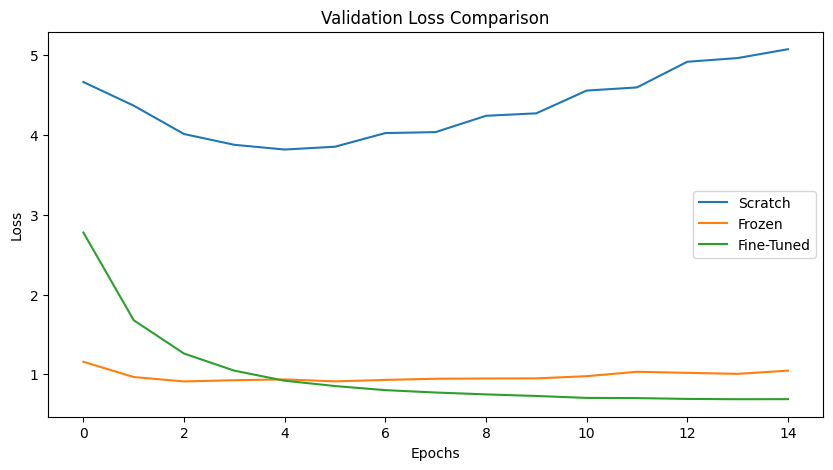

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(scratch['val_loss'], label='Scratch')
plt.plot(frozen['val_loss'], label='Frozen')
plt.plot(finetune['val_loss'], label='Fine-Tuned')
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
acc_scratch, f1_scratch = evaluate_model(baseline_model, test_loader, "Baseline CNN")
acc_frozen, f1_frozen = evaluate_model(frozen_model, test_loader, "Frozen ResNet18")
acc_ft, f1_ft = evaluate_model(partial_finetune_model, test_loader, "Fine-Tuned ResNet18")


--- Evaluation Results for Baseline CNN ---
Accuracy: 0.2467
F1 Score (Weighted): 0.2351

--- Evaluation Results for Frozen ResNet18 ---
Accuracy: 0.7844
F1 Score (Weighted): 0.7865

--- Evaluation Results for Fine-Tuned ResNet18 ---
Accuracy: 0.8393
F1 Score (Weighted): 0.8389


Partially fine tuned model performs the best. This is because of the following reasons:
- Caltech 256 is medium sized. About 20k images across 257 classes.
- Training from scratch needs far more data. The scratch model overfits early. Validation loss rises.
- Pretrained features already capture edges, textures, and shapes. These transfer well to Caltech object categories.
- Fully frozen models cannot adapt high level features.
- Domain shift exists. Caltech images differ from ImageNet in backgrounds, object scale, and composition.
- Frozen models hit a performance ceiling.


# Question 6: Conceptual Understanding(2 marks)

Why is transfer learning effective for large multi-class datasets like Caltech-256?

What are the main limitations of transfer learning when dataset classes differ significantly from the pretrained dataset?

1.
- Visual features are reusable.
Edges, corners, textures, and object parts appear across many categories.
ImageNet pretraining already learns these features.

- Caltech 256 has many classes.
257 classes increase decision boundary complexity.
Learning good features from scratch needs far more labeled data per class.

2.
- Feature Irrelevance: If we move from natural photos (ImageNet) to specialized domains like Medical X-rays or SAR Satellite imagery, high-level features like "ears" or "pavement" become useless noise.

- Negative Transfer: The model may try to force-fit patterns from its original training onto the new data, leading to worse performance than a smaller, custom-built model.